In [21]:
# Connect Google drive with Google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Before diving into the analysis, let's briefly recap the variables provided:**

- TransactionID: Unique identifier for each transaction.
- ProductID: Unique identifier for each product.
- Date: Date of the transaction.
- Price: Price of the product.
- Quantity: Quantity of the product sold.
- CustomerID: Unique identifier for each customer.
- PaymentMethod: Payment method used.
- Region: Geographical region of the transaction.
- Potential Analysis Areas
  https://www.kaggle.com/datasets/arnavsmayan/online-retail-sales-dataset
1. **RFM Analysis:**

- Recency: How recently did a customer make a purchase?
- Frequency: How often does a customer make purchases?
- Monetary: How much money does a customer spend?
- By calculating these metrics, you can segment customers into groups like "high-value," "low-value," "churn risk," etc.

2. **Product Affinity Analysis:**

- Identify products frequently purchased together.
- Use association rule mining techniques (e.g., Apriori, FP-growth) to discover patterns.
- Create product bundles or cross-selling recommendations.

3. **Customer Lifetime Value (CLTV) Analysis:**

- Predict the total revenue a customer will generate over their lifetime.
- Use historical data and statistical models to estimate CLTV.
- Prioritize customers with high CLTV for targeted marketing and retention efforts.

4. **Purchase Behavior Analysis:**

- Analyze purchase patterns (e.g., time of day, day of week, seasonality).
- Identify trends and preferences to optimize marketing strategies.
- Segment customers based on purchase behavior (e.g., impulse buyers, planned buyers).

5. **Geographic Segmentation:**

- Analyze sales data by region to identify regional preferences and trends.
- Tailor marketing campaigns and product offerings to specific regions.

6. **Payment Method Analysis:**

- Analyze the distribution of payment methods used by customers.
- Identify any preferences or trends related to payment methods.
- Optimize payment options based on customer preferences.

7. **Churn Analysis:**

- Predict customers who are likely to stop doing business with the company.
- Use predictive modeling techniques (e.g., logistic regression, survival analysis) to identify at-risk customers.
- Implement retention strategies to prevent customer churn.

- Note: The specific analysis methods and techniques used will depend on the company's goals, resources, and the complexity of the data. It's often a combination of these approaches that provides the most valuable insights.

<font color='blue'> <font size='6'> **RFM Analysis**

In [22]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For better visualization
sns.set(style='whitegrid')


In [28]:
file_path = '/content/drive/My Drive/retail.csv'  # Replace 'MyDrive' with the appropriate folder name
df = pd.read_csv(file_path)

# Display first few rows to get a sense of the data
df.head()



,transaction_id,Date_of_Sale,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount
0,1,01-01-2023 00:00,1993,915,Home & Kitchen,8,103.30,0.23,Gift Card,27,Female,North America,636.33
1,2,01-01-2023 00:01,3474,553,Clothing,9,180.28,0.31,Gift Card,53,Other,South America,1119.54
2,3,01-01-2023 00:02,4564,248,Beauty & Personal Care,7,81.58,0.27,Debit Card,34,Other,North America,416.87
3,4,01-01-2023 00:03,1133,948,Clothing,3,235.20,0.00,Debit Card,50,Other,Australia,705.60
4,5,01-01-2023 00:04,3626,284,Books,9,453.00,0.34,Credit Card,23,Female,Australia,2690.82


In [29]:
# Rename the column
df = df.rename(columns={'Date_of_Sale': 'Date'})
df.head()

,transaction_id,Date,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount
0,1,01-01-2023 00:00,1993,915,Home & Kitchen,8,103.30,0.23,Gift Card,27,Female,North America,636.33
1,2,01-01-2023 00:01,3474,553,Clothing,9,180.28,0.31,Gift Card,53,Other,South America,1119.54
2,3,01-01-2023 00:02,4564,248,Beauty & Personal Care,7,81.58,0.27,Debit Card,34,Other,North America,416.87
3,4,01-01-2023 00:03,1133,948,Clothing,3,235.20,0.00,Debit Card,50,Other,Australia,705.60
4,5,01-01-2023 00:04,3626,284,Books,9,453.00,0.34,Credit Card,23,Female,Australia,2690.82


In [30]:
# Check for missing values
missing_values = df.isnull().sum()

# Fill or drop missing values
df = df.dropna()  # Dropping rows with missing data, alternatively, you can fill missing values


In [31]:
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows where 'Date' could not be converted
df = df.dropna(subset=['Date'])
df.head()


,transaction_id,Date,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount
0,1,2023-01-01 00:00:00,1993,915,Home & Kitchen,8,103.30,0.23,Gift Card,27,Female,North America,636.33
1,2,2023-01-01 00:01:00,3474,553,Clothing,9,180.28,0.31,Gift Card,53,Other,South America,1119.54
2,3,2023-01-01 00:02:00,4564,248,Beauty & Personal Care,7,81.58,0.27,Debit Card,34,Other,North America,416.87
3,4,2023-01-01 00:03:00,1133,948,Clothing,3,235.20,0.00,Debit Card,50,Other,Australia,705.60
4,5,2023-01-01 00:04:00,3626,284,Books,9,453.00,0.34,Credit Card,23,Female,Australia,2690.82


In [33]:
# Create the 'totalprice' column by multiplying Price by Quantity
df['totalprice'] = df['price'] * df['quantity']


**Feature Engineering for RFM**

Calculate Recency, Frequency, and Monetary for each customer:

In [36]:
# Set today as the max date for recency calculation
current_date = df['Date'].max() + pd.Timedelta(days=1)

# RFM Table
rfm_table = df.groupby('customer_id').agg({
    'Date': lambda x: (current_date - x.max()).days,  # Recency
    'transaction_id': 'count',  # Frequency
    'totalprice': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm_table.columns = ['Customerid', 'Recency', 'Frequency', 'Monetary']

# Display the RFM table
rfm_table.head()



,Customerid,Recency,Frequency,Monetary
0,1000,2,85,110457.35
1,1001,5,99,110898.49
2,1002,3,122,180864.78
3,1003,1,100,138137.92
4,1004,1,110,126236.85


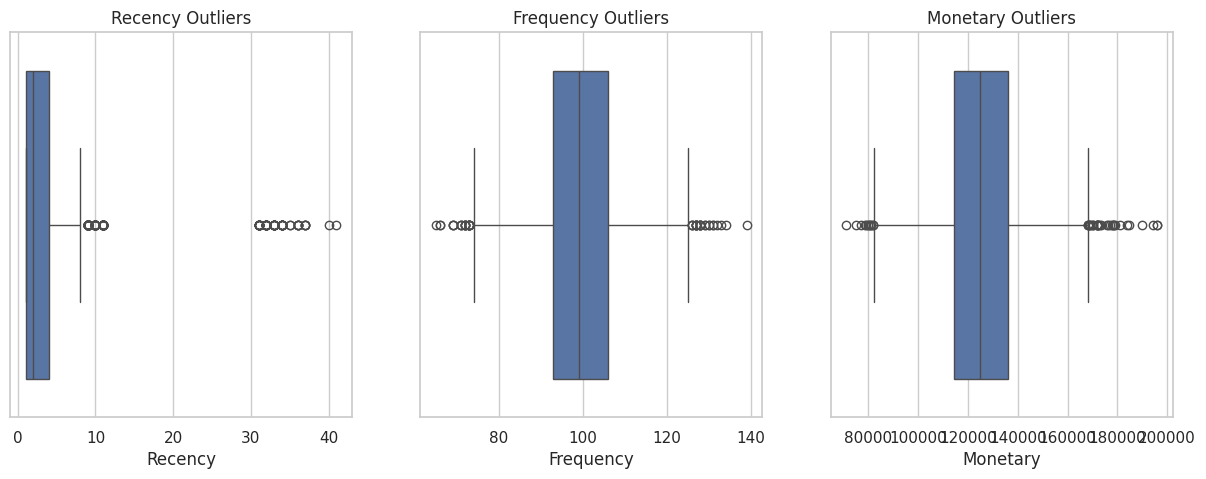

In [37]:
# Plot boxplots for Recency, Frequency, and Monetary to identify outliers
plt.figure(figsize=(15,5))

# Recency boxplot
plt.subplot(1, 3, 1)
sns.boxplot(x=rfm_table['Recency'])
plt.title('Recency Outliers')

# Frequency boxplot
plt.subplot(1, 3, 2)
sns.boxplot(x=rfm_table['Frequency'])
plt.title('Frequency Outliers')

# Monetary boxplot
plt.subplot(1, 3, 3)
sns.boxplot(x=rfm_table['Monetary'])
plt.title('Monetary Outliers')

plt.show()


In [46]:
# Quantile-based scoring for Recency, Frequency, and Monetary
rfm_table['R_Score'] = pd.qcut(rfm_table['Recency'], 4, labels=[4, 3, 2], duplicates='drop')
rfm_table['F_Score'] = pd.qcut(rfm_table['Frequency'].rank(method='dense'), 4, labels=[1, 2, 3, 4])
rfm_table['M_Score'] = pd.qcut(rfm_table['Monetary'], 4, labels=[1, 2, 3, 4])

# ... rest of your code

# Sum the RFM scores
rfm_table['RFM_Score'] = rfm_table['R_Score'].astype(str) + rfm_table['F_Score'].astype(str) + rfm_table['M_Score'].astype(str)

# Display the final RFM table
rfm_table.head()


,Customerid,Recency,Frequency,Monetary,F_Score,M_Score,R_Score,RFM_Score
0,1000,2,85,110457.35,1,1,4,411
1,1001,5,99,110898.49,2,1,2,221
2,1002,3,122,180864.78,4,4,3,344
3,1003,1,100,138137.92,3,4,4,434
4,1004,1,110,126236.85,4,3,4,443


In [47]:
# Define RFM segments based on scores
def rfm_segment(x):
    if x == '444':
        return 'Top Customers'
    elif x[0] == '4':
        return 'Loyal Customers'
    elif x[1] == '4':
        return 'Frequent Customers'
    elif x[2] == '4':
        return 'Big Spenders'
    else:
        return 'Others'

rfm_table['RFM_Segment'] = rfm_table['RFM_Score'].apply(rfm_segment)

# Count the number of customers in each segment
rfm_table['RFM_Segment'].value_counts()


,count
RFM_Segment,
Loyal Customers,1728
Others,1363
Frequent Customers,407
Top Customers,335
Big Spenders,167


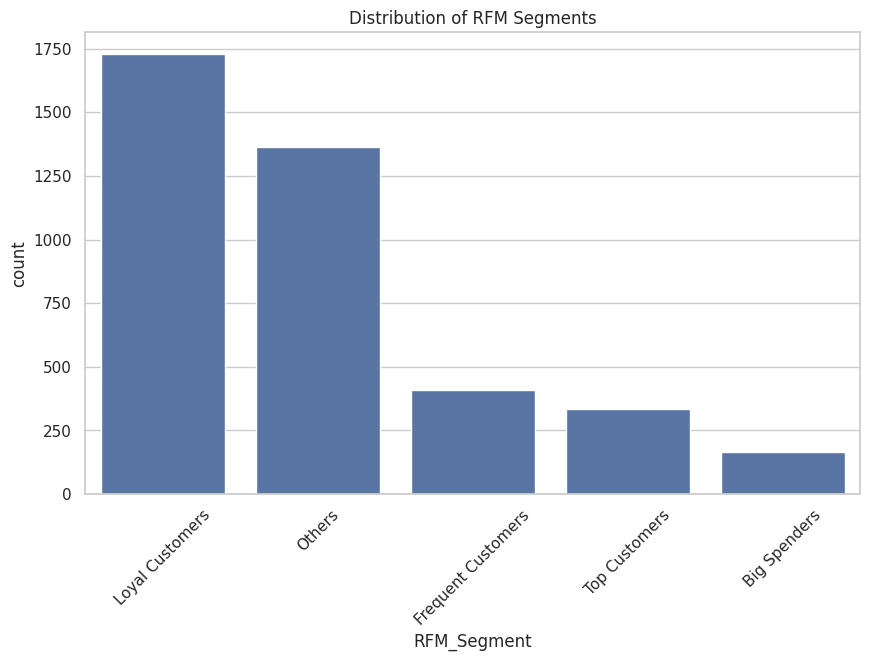

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(x='RFM_Segment', data=rfm_table, order=rfm_table['RFM_Segment'].value_counts().index)
plt.title('Distribution of RFM Segments')
plt.xticks(rotation=45)
plt.show()


In [51]:
# Save RFM table to CSV
rfm_table.to_csv('rfm_analysis_results.csv', index=False)
